# HW2: Model Inference of the Pretrained LeNet

<font color='red'>Name: 陳力豪 Student ID: 107061272 </font>

## 1. High-level Function Implementation for Each Layer
Implement a high-level functional model for each layer of the CNN, including convolution, pooling, and 
fully-connected layer with 8-bit quantization of the input activations, output activations, and weights accordingly.
* Learn how to use [Numba](https://numba.pydata.org/) to accelerate python functions
* Fill in the TODOs in `functional.py` of `nnutils`.
    * You must consider `psum_range = (lower_bound, upper_bound)` which controls the precision of partial sums.
    * `psum_record_list` will be used in *2. Bit-width of Partial Sums*, so you may leave it alone for now.
    
### 1.1 Pass all Unit Tests of OpTestCase in `nnunittest.py`.
First, use 32-bit signed integers for the partial sums to pass the unit tests. The accumulation of activations is limited to 32 bits in convolution and fully-connected layers. Clamp the value if it exceeds the minimum or maximum values of the 32-bit signed number.

Note that you should implement convolution layers, fully-connected layers, and max-pooling layers with "nested loops" by yourself. You are not allowed to use existing functions (e.g., `conv2d` in `numpy` or `pytorch`). Or you will not get any credits. Raise questions when in doubt.

There are eight unit tests you need to pass. If you intend to run part of them, follow the steps:
```
tests = ['test_C1', 'test_C3']
suite = unittest.TestSuite(map(nnunittest.OpTestCase, tests))
```

In [1]:
import unittest
import nnunittest

#tests = ['test_C1']
#suite = unittest.TestSuite(map(nnunittest.OpTestCase, tests))
suite = unittest.TestLoader().loadTestsFromTestCase(nnunittest.OpTestCase)
unittest.TextTestRunner(verbosity=2).run(suite)

test_C1 (nnunittest.OpTestCase) ... ok
test_C3 (nnunittest.OpTestCase) ... ok
test_C5 (nnunittest.OpTestCase) ... ok
test_F6 (nnunittest.OpTestCase) ... ok
test_OUTPUT (nnunittest.OpTestCase) ... ok
test_S2 (nnunittest.OpTestCase) ... ok
test_S4 (nnunittest.OpTestCase) ... ok
test_edges (nnunittest.OpTestCase) ... ok

----------------------------------------------------------------------
Ran 8 tests in 18.505s

OK


<unittest.runner.TextTestResult run=8 errors=0 failures=0>

### 1.2 Reconstruct the LeNet in HW1
* Fill in the TODO in `forward()` of `LeNet`.
* Test the model with the test dataset. There should be no accuracy degradation if you have done everything correctly.

In [2]:
from nnutils import LeNet
import nnutils.test as test
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
    ])

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

def run_LeNet(n_bit, max_samples = None):
    number_range = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
    print("bit:", n_bit)
    print("bit-width range:",number_range)

    psum_range = {
        'c1': number_range,
        'c3': number_range,
        'c5': number_range,
        'f6': number_range,
        'output': number_range
    }

    model = LeNet(psum_range)

    return test(model, testloader)

run_LeNet(n_bit = 32)

bit: 32
bit-width range: (-2147483648, 2147483647)
Accuracy: 98.82%


98.82

## 2. Bit-width of Partial Sums
### 2.1 Question: Find the minimum bit-width of partial sums for all layers with the highest accuracy
1. Use matplotlib to plot "Test Accuracy(%)" versus "Bit-width of Partial Sums" for "Bit-width of Partial Sums" in $[2, 32]$ by `matplotlib.pyplot.plot()`.
    * [Plot with matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html).
2. What is the smallest bit-width of partial sums that maintains the same accuracy from the previous plot?

### 2.1 Answers
<font color='red'>Write your answers here.</font>
1. The "Test Accuracy(%)" versus "Bit-width of Partial Sums" graph as following. </br>
</br>
2. The smallest bit-width to maintain the same accuracy as the previous result is 「18」

bit: 2
bit-width range: (-2, 1)
Accuracy: 11.35%
bit: 4
bit-width range: (-8, 7)
Accuracy: 11.35%
bit: 6
bit-width range: (-32, 31)
Accuracy: 11.35%
bit: 8
bit-width range: (-128, 127)
Accuracy: 11.35%
bit: 10
bit-width range: (-512, 511)
Accuracy: 11.35%
bit: 12
bit-width range: (-2048, 2047)
Accuracy: 11.35%
bit: 14
bit-width range: (-8192, 8191)
Accuracy: 43.33%
bit: 16
bit-width range: (-32768, 32767)
Accuracy: 97.88%
bit: 18
bit-width range: (-131072, 131071)
Accuracy: 98.82%
bit: 20
bit-width range: (-524288, 524287)
Accuracy: 98.82%
bit: 22
bit-width range: (-2097152, 2097151)
Accuracy: 98.82%
bit: 24
bit-width range: (-8388608, 8388607)
Accuracy: 98.82%
bit: 26
bit-width range: (-33554432, 33554431)
Accuracy: 98.82%
bit: 28
bit-width range: (-134217728, 134217727)
Accuracy: 98.82%
bit: 30
bit-width range: (-536870912, 536870911)
Accuracy: 98.82%
bit: 32
bit-width range: (-2147483648, 2147483647)
Accuracy: 98.82%


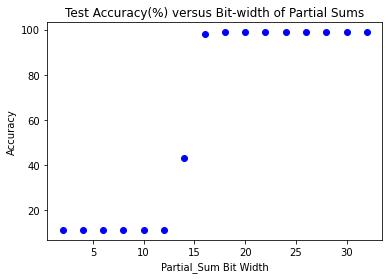

In [3]:
import matplotlib.pyplot as plt
acc = []
for i in range(1, 17):
    acc.append(run_LeNet(i*2))

# TODO 
Bit_w = []
for i in range(1,17):
    Bit_w.append(i*2)
    

plt.plot(Bit_w, acc, 'bo')
plt.xlabel('Partial_Sum Bit Width')
plt.ylabel('Accuracy')
plt.title('Test Accuracy(%) versus Bit-width of Partial Sums')
plt.show()

### 2.2 Question: Find the minimum bit-width of partial sums for each layer with the highest accuracy
1. Plot the distribution of partial sums of each quantized layer in the CNN with the MNIST test dataset. Write down the min, max, and standard deviation for each layer. 
    * Check the TODO in `LeNet` of `LeNetModel`. You should save all partial sums to the dictionary, `psum_record_dict`.
    * We can get this dictionary after running the model with the first image in the test dataset by `model.psum_record_dict`.
2. Determine the minimum bit-width of partial sums in each layer without hurting the accuracy. 
    * Fill in the TODO to see if the accuracy is still the same.
    * Show the accuracy after doing so.

### 2.2 Answers
<font color='red'>Write your answers here.</font>
1.  </br>
c1_psum: [min, max] = [-82748, 77317] </br>
c1_psum_std: 19087.927796427335</br>
</br>
c3_psum: [min, max] = [-59001, 25314] </br>
c3_psum_std: 9285.67338034872</br>
</br>
c5_psum: [min, max] = [-64026, 44412] </br>
c5_psum_std: 17985.371220398036</br>
</br>
f6_psum: [min, max] = [-51320, 34615] </br>
f6_psum_std: 12958.600253292167</br>
</br>
output_psum: [min, max] = [-57210, 13984] </br>
output_psum_std: 11177.661154953674</br>
</br>

2. The minimum bit-width to maintain the same accuracy:</br>
C1_bit_width = 18 bits</br>
C3_bit_width = 16 bits</br>
C5_bit_width = 17 bits</br>
F6_bit_width = 16 bits</br>
Output_bit_width = 15 bits</br>

bit: 32
bit-width range: (-2147483648, 2147483647)


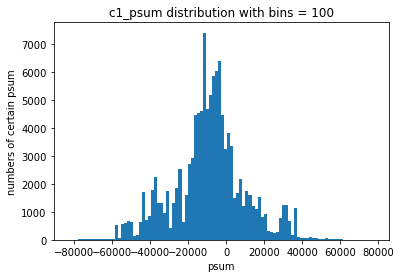

c1_psum: [min, max] = [-82748, 77317] 
c1_psum_std: 19087.927796427335


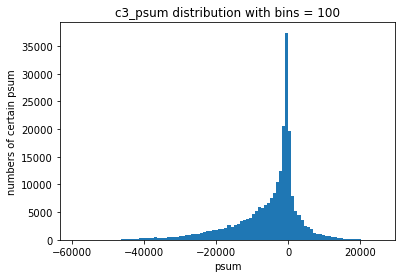

c3_psum: [min, max] = [-59001, 25314] 
c3_psum_std: 9285.67338034872


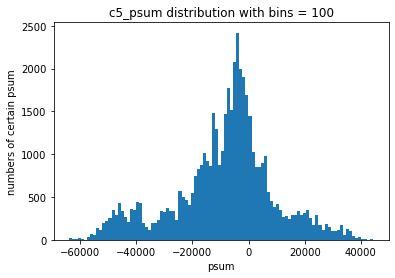

c5_psum: [min, max] = [-64026, 44412] 
c5_psum_std: 17985.371220398036


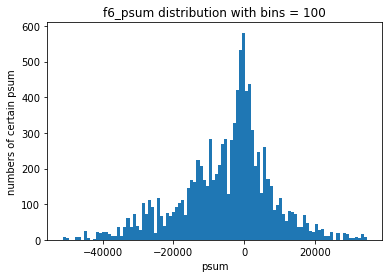

f6_psum: [min, max] = [-51320, 34615] 
f6_psum_std: 12958.600253292167


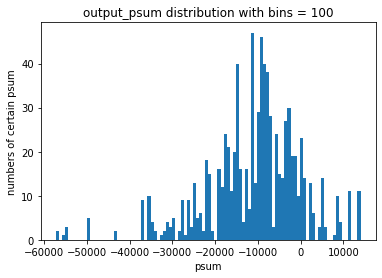

output_psum: [min, max] = [-57210, 13984] 
output_psum_std: 11177.661154953674


In [4]:
import numpy as np
import matplotlib.pyplot as plt
n_bit = 32
number_range = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
print("bit:", n_bit)
print("bit-width range:",number_range)

psum_range = {
    'c1': number_range,
    'c3': number_range,
    'c5': number_range,
    'f6': number_range,
    'output': number_range
}

model = LeNet(psum_range)

image = np.expand_dims(testset[0][0], axis=0)
_ = model.forward(image, psum_record = True)

# TODO
# Plot the distribution of partial sums of each quantized layer in the CNN
c1_psum_record = model.psum_record_dict['c1']
c3_psum_record = model.psum_record_dict['c3']
c5_psum_record = model.psum_record_dict['c5']
f6_psum_record = model.psum_record_dict['f6']
output_psum_record = model.psum_record_dict['output']

c1_psum_max = np.max(c1_psum_record)
c1_psum_min = np.min(c1_psum_record)
c1_psum_std = np.std(c1_psum_record)
c3_psum_max = np.max(c3_psum_record)
c3_psum_min = np.min(c3_psum_record)
c3_psum_std = np.std(c3_psum_record)
c5_psum_max = np.max(c5_psum_record)
c5_psum_min = np.min(c5_psum_record)
c5_psum_std = np.std(c5_psum_record)
f6_psum_max = np.max(f6_psum_record)
f6_psum_min = np.min(f6_psum_record)
f6_psum_std = np.std(f6_psum_record)
output_psum_max = np.max(output_psum_record)
output_psum_min = np.min(output_psum_record)
output_psum_std = np.std(output_psum_record)

# C1
hist_c1_psum, bins_c1_psum = np.histogram(c1_psum_record , bins=100)
plt.hist(bins_c1_psum[:-1], bins_c1_psum, weights=hist_c1_psum)
plt.xlabel("psum")
plt.ylabel("numbers of certain psum")
plt.title("c1_psum distribution with bins = 100") 
plt.show()
print("c1_psum: [min, max] = [{}, {}] ".format(c1_psum_min, c1_psum_max))
print("c1_psum_std: {}".format(c1_psum_std))

# C3
hist_c3_psum, bins_c3_psum = np.histogram(c3_psum_record , bins=100)
plt.hist(bins_c3_psum[:-1], bins_c3_psum, weights=hist_c3_psum)
plt.xlabel("psum")
plt.ylabel("numbers of certain psum")
plt.title("c3_psum distribution with bins = 100") 
plt.show()
print("c3_psum: [min, max] = [{}, {}] ".format(c3_psum_min, c3_psum_max))
print("c3_psum_std: {}".format(c3_psum_std))

# C5
hist_c5_psum, bins_c5_psum = np.histogram(c5_psum_record , bins=100)
plt.hist(bins_c5_psum[:-1], bins_c5_psum, weights=hist_c5_psum)
plt.xlabel("psum")
plt.ylabel("numbers of certain psum")
plt.title("c5_psum distribution with bins = 100") 
plt.show()
print("c5_psum: [min, max] = [{}, {}] ".format(c5_psum_min, c5_psum_max))
print("c5_psum_std: {}".format(c5_psum_std))

# F6
hist_f6_psum, bins_f6_psum = np.histogram(f6_psum_record , bins=100)
plt.hist(bins_f6_psum[:-1], bins_f6_psum, weights=hist_f6_psum)
plt.xlabel("psum")
plt.ylabel("numbers of certain psum")
plt.title("f6_psum distribution with bins = 100") 
plt.show()
print("f6_psum: [min, max] = [{}, {}] ".format(f6_psum_min, f6_psum_max))
print("f6_psum_std: {}".format(f6_psum_std))

# Output
hist_output_psum, bins_output_psum = np.histogram(output_psum_record , bins=100)
plt.hist(bins_output_psum[:-1], bins_output_psum, weights=hist_output_psum)
plt.xlabel("psum")
plt.ylabel("numbers of certain psum")
plt.title("output_psum distribution with bins = 100") 
plt.show()
print("output_psum: [min, max] = [{}, {}] ".format(output_psum_min, output_psum_max))
print("output_psum_std: {}".format(output_psum_std))


In [5]:
# TODO
# Test your model with those Bit-widths you choose 

for c1 in [18]:
    for c3 in [16]:
        for c5 in [17]:
            for f6 in [15,16]:
                for output in [15,16]:
                    print("c1_bit: {}".format(c1))
                    print("c1_bit width range: ({}, {})".format(-(2**(c1-1)), 2**(c1-1) - 1))
                    print("c3_bit: {}, ".format(c3))
                    print("c3_bit width range: ({}, {})".format(-(2**(c3-1)), 2**(c3-1) - 1))
                    print("c5_bit: {}, ".format(c5))
                    print("c5_bit width range: ({}, {})".format(-(2**(c5-1)), 2**(c5-1) - 1))
                    print("f6_bit: {}, ".format(f6))
                    print("f6_bit width range: ({}, {})".format(-(2**(f6-1)), 2**(f6-1) - 1))
                    print("output_bit: {}, ".format(output))
                    print("output_bit width range: ({}, {})".format(-(2**(output-1)), 2**(output-1) - 1))
                    psum_range = {
                        'c1': (-(2**(c1-1)), 2**(c1-1) - 1),
                        'c3': (-(2**(c3-1)), 2**(c3-1) - 1),
                        'c5': (-(2**(c5-1)), 2**(c5-1) - 1),
                        'f6': (-(2**(f6-1)), 2**(f6-1) - 1),
                        'output': (-(2**(output-1)), 2**(output-1) - 1)
                    }
                    model = LeNet(psum_range)

                    _ = test(model, testloader)
                    print("-------------------------------------------------------")

c1_bit: 18
c1_bit width range: (-131072, 131071)
c3_bit: 16, 
c3_bit width range: (-32768, 32767)
c5_bit: 17, 
c5_bit width range: (-65536, 65535)
f6_bit: 15, 
f6_bit width range: (-16384, 16383)
output_bit: 15, 
output_bit width range: (-16384, 16383)
Accuracy: 98.79%
-------------------------------------------------------
c1_bit: 18
c1_bit width range: (-131072, 131071)
c3_bit: 16, 
c3_bit width range: (-32768, 32767)
c5_bit: 17, 
c5_bit width range: (-65536, 65535)
f6_bit: 15, 
f6_bit width range: (-16384, 16383)
output_bit: 16, 
output_bit width range: (-32768, 32767)
Accuracy: 98.79%
-------------------------------------------------------
c1_bit: 18
c1_bit width range: (-131072, 131071)
c3_bit: 16, 
c3_bit width range: (-32768, 32767)
c5_bit: 17, 
c5_bit width range: (-65536, 65535)
f6_bit: 16, 
f6_bit width range: (-32768, 32767)
output_bit: 15, 
output_bit width range: (-16384, 16383)
Accuracy: 98.82%
-------------------------------------------------------
c1_bit: 18
c1_bit widt

## 3. Evaluation: Energy Model
### 3.1 Question: Evaluate these two approaches based on the following energy model:
$$E_w = s_{mul}\times N_{mul} + s_{add}\times N_{add}$$
$$s_{mul} = 64\times \left(\frac{B_{mul}}{8}\right)^2, s_{add} = B_{add}$$
where $N_{mul}$ and $N_{add}$ are the number of multiplications and additions, respectively. $B_{mul}$ and $B_{add}$ are the bit-widths of multiplier and adder, respectively. $s_{mul}$ denotes the power scaling factor of multiplication; $s_{add}$ denotes the power scaling factor of addition.
* You must accumulate the energy layer by layer to obtain the overall $E_w$, if each layer has a  different $B_{mul}$ or $B_{add}$.
* We only consider convolution and fully-connected operations, ignoring pooling and ReLU operations in this energy model.
* Disclaimer: Note that this energy model is artificial and oversimplified. DO NOT apply it to your research work.

1. Calculate the overall $E_w$ for the setup of 2.1.
2. Calculate the energy layer by layer and also the overall $E_w$ for the setup of 2.2.

# 3.1 Answers
<font color='red'>Write your answers here.</font>
1. </br>
$B_{mul} = 8 $</br>
$B_{add} = 18$</br>
$s_{mul} = 64\times \left(\frac{8}{8}\right)^2 = 64$</br>
$s_{add} = 18$</br>
$L_{N_{mul}}$ = $H\times C\times W$ </br>
$L_{N_{add}}$ = $H\times C\times W + H\times C$</br>
$C_{N_{mul}}$ = $N\times M\times((H-$kernel_size$)/stride)+1)\times(W-$kernel_size$)/stride)\times R\times S\times C_{x}$</br>
$C_{N_{add}}$ = $N\times M\times((H-$kernel_size$)/stride)+1)\times(W-$kernel_size$)/stride)\times R\times S\times C_{x}$</br>
$Kernel Size = 5$</br> 
$Stride = 1$</br>
</br>
$E_{c1}$ = $s_{mul}\times C_{N_{mul}}$ + $s_{add} \times C_{N_{add}}  = 38572800$</br>
$E_{c3}$ = $s_{mul}\times C_{N_{mul}}$ + $s_{add} \times C_{N_{add}}  = 78720000$</br>
$E_{c5}$ = $s_{mul}\times C_{N_{mul}}$ + $s_{add} \times C_{N_{add}}  = 15744000$</br>
$E_{f6}$ = $s_{mul}\times L_{N_{mul}}$ + $s_{add} \times L_{N_{add}}  = 3312288$</br>
$E_{out}$ = $s_{mul}\times L_{N_{mul}}$ + $s_{add} \times L_{N_{add}} = 276240$</br>
$E_w$ = $E_{c1}$ + $E_{c3}$ + $E_{c5}$ + $E_{f6}$ + $E_{out} = 136,625,328$</br>



2. </br>
</br>
$E_{c1}$ = $s_{mul}\times C_{N_{mul}}$ + $s_{add} \times C_{N_{add}}  = 38572800$ 
where $s_{mul} = 64\times \left(\frac{8}{8}\right)^2 = 64$ , $s_{add} = 18$</br>
</br>
$E_{c3}$ = $s_{mul}\times C_{N_{mul}}$ + $s_{add} \times C_{N_{add}}  = 76800000$ 
where $s_{mul} = 64\times \left(\frac{8}{8}\right)^2 = 64$ , $s_{add} = 16$</br>
</br>
$E_{c5}$ = $s_{mul}\times C_{N_{mul}}$ + $s_{add} \times C_{N_{add}}  = 15552000$
where $s_{mul} = 64\times \left(\frac{8}{8}\right)^2 = 64$ , $s_{add} = 17$</br>
</br>
$E_{f6}$ = $s_{mul}\times L_{N_{mul}}$ + $s_{add} \times L_{N_{add}}  = 3230976$
where $s_{mul} = 64\times \left(\frac{8}{8}\right)^2 = 64$ , $s_{add} = 16$</br>
</br>
$E_{out}$ = $s_{mul}\times L_{N_{mul}}$ + $s_{add} \times L_{N_{add}} = 266040$
where $s_{mul} = 64\times \left(\frac{8}{8}\right)^2 = 64$ , $s_{add} = 15$</br>
</br>
$E_w$ = $E_{c1}$ + $E_{c3}$ + $E_{c5}$ + $E_{f6}$ + $E_{out} = 134,421,816$